# Linear Regression with Regularization

In this notebook, you will create a **gradient descent** solver for **ridge regression** and **lasso regression** then compare it to the built-in libraries in `sklearn.linear_model`.

## Set up notebook and load data set

After loading in some standard packages, we load synthetic data set consisting of data points `(x,y)`:
* `x`: 100-dimensional vector whose coordinates are independent draws from a standard normal (Gaussian) distribution
* `y`: response value given by `y = wx + e` where `w` is a target regression function and `e` is Gaussian noise. **`y` was generated using only 10 of the 100 features (which are unknown to you, at least for now!).**}

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

This next snippet of code loads in the dataset. There are 100 data points for train and test set respectively, each with 100 predictor variables (which we'll denote `x`) and one response variable (which we'll denote `y`).

Make sure the files `'trainx.csv'`,`'trainy.csv'`,`'testx.csv'`, and `'testy.csv'` are in the same directory as this notebook.


In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

trainx = np.genfromtxt('trainx.csv', delimiter=',')
testx = np.genfromtxt('testx.csv', delimiter=',')
trainy = np.genfromtxt('trainy.csv', delimiter=',')[np.newaxis]
testy = np.genfromtxt('testy.csv', delimiter=',')[np.newaxis]

# scaling
trainy = StandardScaler().fit(trainy).transform(trainy)
trainx = StandardScaler().fit(trainx).transform(trainx)
testy = StandardScaler().fit(testy).transform(testy)
testx = StandardScaler().fit(testx).transform(testx)


print('trainx', trainx.shape,
      '\ntrainy', trainy.shape,
      '\ntestx', testx.shape,
      '\ntesty', testy.shape)

trainx (100, 100) 
trainy (1, 100) 
testx (100, 100) 
testy (1, 100)


## 1. Gradient descent solver for ridge regression

<font color="magenta">**For you to do:**</font> Define a procedure, **ridge_regression_GD**, that uses gradient descent to solve the ridge regression problem. It is invoked as follows:

* `w,b,losses = ridge_regression_GD(x,y,C)`

Here, the input consists of:
* training data `trainx, trainy`, where `trainx` and `trainy` are numpy arrays of dimension `m`-by-`n` and `m`, respectively (if there are `m` training points and `n` features)
* regularization constant `C`, we normally use the term **lambda**.

The function should find the `n`-dimensional vector `w` and offset `b` that minimize the MSE loss function (with regularization constant `C`), and return:
* `w` and `b`
* `losses`, an array containing the MSE loss at each iteration

<font color="magenta">Advice:</font> First figure out the derivative, which has a relatively simple form. Next, when implementing gradient descent, think carefully about two issues.

1. What is the step size (learning rate)?
2. When has the procedure converged?

Take the time to experiment with different ways of handling these.

**Note:** You can use additional methods as helpers if you feel the need.

In [23]:
# m: the number of samples

def concat_bias_column_as_feature(X):
    """@param X - the training featuers m by n, appends a bias column as 1's to the beginning"""
    return np.hstack((np.ones(X.shape[0])[np.newaxis].T, X)) # adding a column of 1's (this is for the bias)

def predict(X, W):
    return np.dot(X, W)

def loss(X, Y, W, C=0, ridge=False):
    """
    @param c - the regularization constant
    @param ridge - if True, will compute "Ridge" regularization
    """
    m = X.shape[1]
    Y_hat = predict(X, W)
    reg_term = np.linalg.norm(W) ** 2 if ridge else np.linalg.norm(W)

    return 1.0/2.0 * np.mean((Y - Y_hat) ** 2) + C * reg_term / m


def loss_derivative(X, Y, W, C=0, ridge=False):
    m = X.shape[1]
    reg_term = 2 * np.linalg.norm(W) if ridge else 1
    
    return -1.0 / m * (np.sum(np.dot(Y - predict(X, W), X)) + C * reg_term)


In [24]:
def regression_GD_general(x, y, C=0, ridge=False, n_epochs=1e4, lr=0.001, epsilon=1e-14, random_state=None):
    """
    :param x: training data points
    :param y: training labels
    :param C: regularization constant
    :param ridge: boolean, True if ridge regularization, else Lasso
    :param n_epochs: 
    :param lr: learning rate
    :param epsilon: stop when delta_loss < epsilon
    :param random_state: random seed for weight initialization
    :return: w, b, training_losses
    """
    # adding the bias in the beginning of the X (to make things simpler)
    X = concat_bias_column_as_feature(x)
    
    np.random.seed(random_state) # setting random seed for weight initialization
    # creating a weights vector that contains the bias as well
    W = np.random.randn(X.shape[1])
    Y = y
    m = X.shape[1]
    
#     print("X:", X.shape)
#     print("Y:", Y.shape)
#     print("W:", W.shape)

    last_loss = np.Inf
    training_losses = []
    for e in range(int(n_epochs)):
        delta_W = loss_derivative(X, y, W, C=C, ridge=ridge)
#         print('delta_W',delta_W.shape)
        err = loss(X, y, W, C=C, ridge=ridge)
        
        W = W - lr * ( delta_W)  # updating weights

        # print("{}: Loss={}".format(e, err))
        # the bellow is just logging/printing stuff
        training_losses.append(err)
        if np.abs(err - last_loss) < epsilon:
            print(f'STOPPING EARLY at epoch {e} (epsilon={epsilon})')
            break
        else:
            last_loss = err

    w, b = W[1:], W[0] # splitting the joint weights:bias, into 2 variables
    
    print('final loss={:.5f}'.format(training_losses[-1]))
    return w, b, training_losses


In [25]:
def ridge_regression_GD(x, y, C, **kwargs):
    return regression_GD_general(x, y, C, ridge=True, **kwargs)

Let's try it out and print a graph of the loss values during the optimization process.

STOPPING EARLY at epoch 254 (epsilon=1e-14)
final loss=47.92181
|W|=10.47


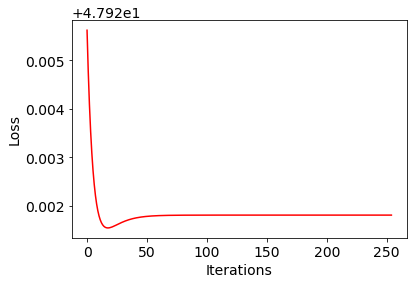

In [27]:
# Set regularization constant
C = 1.0 # you can try different values for C
# Run gradient descent solver
w, b, losses = ridge_regression_GD(trainx, trainy, C, n_epochs=1e4, lr=0.001, epsilon=1e-14, random_state=9)
# Plot the losses
plt.plot(losses,'r')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

print('|W|={:.2f}'.format(np.linalg.norm(w)))
# print('W=', w)

## 2. Evaluate the gradient descent solver for ridge regression

Now let's compare the regressor found by your gradient descent procedure to that returned by the built-in ridge regression solver in `sklearn`. We will compare them by their resulting MSE values. We will also compare the results of the built-in linear regression (without regularization).

Complete the following code to compute the MSE value given `w`, `b`, `x`, and `y`.

In [28]:
def compute_mse(w,b,x,y):
    ### START CODE HERE ###
    X = concat_bias_column_as_feature(x) # adding the bias in the beginning of the X (to make things simpler)
    W = np.hstack((b, w))
    m = X.shape[1]
    
    Y_hat = predict(X, W)
    return 1.0/(2.0 * m) * np.sum((y - Y_hat) ** 2)
    ### END CODE HERE ###

In [60]:
# Set regularization constant
C = 1.0 # you can change it
# Run gradient descent solver and compute its MSE
w, b, losses = ridge_regression_GD(trainx, trainy, C, n_epochs=1000, lr=0.001, random_state=9)
# Use built-in routine for linear regression and compute MSE
lin_regr = linear_model.LinearRegression()
lin_regr.fit(trainx, trainy)
# Use built-in routine for ridge regression and compute MSE
ridge_regr = linear_model.Ridge(alpha=1.0) # you can try different values
ridge_regr.fit(trainx, trainy)
# Print MSE values
print("MSE of built-in linear regression(training):                    ", mean_squared_error(lin_regr.predict(trainx), trainy))
print("MSE of gradient descent solver for ridge regression (training): ", compute_mse(w,b,trainx, trainy))
print("MSE of built-in solver for ridge regression (training):         ", mean_squared_error(ridge_regr.predict(trainx), trainy))
print("MSE of built-in linear regression(test):                        ", mean_squared_error(lin_regr.predict(testx), testy))
print("MSE of gradient descent solver for ridge regression (test):     ", compute_mse(w,b,testx, testy))
print("MSE of built-in solver for ridge regression (test):             ", mean_squared_error(ridge_regr.predict(testx), testy))

STOPPING EARLY at epoch 298 (epsilon=1e-14)
final loss=48.79334
MSE of built-in linear regression(training):                     2.263924717762967e-28
MSE of gradient descent solver for ridge regression (training):  47.15829064559563
MSE of built-in solver for ridge regression (training):          0.03480412397500035
MSE of built-in linear regression(test):                         50.89682328293875
MSE of gradient descent solver for ridge regression (test):      54.6861607411059
MSE of built-in solver for ridge regression (test):              4.5901649916210205


## 3. Gradient descent solver for lasso regression

<font color="magenta">**For you to do:**</font> Define a procedure, **lasso_regression_GD**, that uses gradient descent to solve the lasso regression problem. It is invoked as follows:

* `w,b,losses = lasso_regression_GD(x,y,C)`

Here, the input consists of:
* training data `trainx, trainy`, where `trainx` and `trainy` are numpy arrays of dimension `m`-by-`n` and `m`, respectively (if there are `m` training points and `n` features)
* regularization constant `C`, we normally use the term **lambda**.

The function should find the `n`-dimensional vector `w` and offset `b` that minimize the MSE loss function (with regularization constant `C`), and return:
* `w` and `b`
* `losses`, an array containing the MSE loss at each iteration

<font color="magenta">Advice:</font> First figure out the derivative, which has a relatively simple form. Next, when implementing gradient descent, think carefully about two issues.

1. What is the step size (learning rate)?
2. When has the procedure converged?

Take the time to experiment with different ways of handling these.

**Note:** You can use additional methods as helpers if you feel the need.

In [61]:
def lasso_regression_GD(x,y,C, **kwargs):
    return regression_GD_general(x, y, C, ridge=False, **kwargs)

Let's try it out and print a graph of the loss values during the optimization process.

STOPPING EARLY at epoch 261 (epsilon=1e-14)
final loss=47.73688


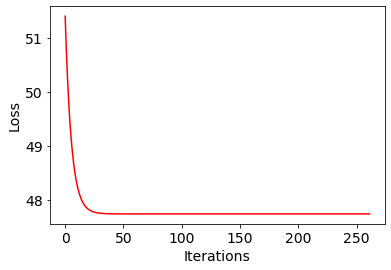

|W|=10.83
Features that have been killed by lasso (|w| <= 0.06) (as indexes):
 (array([ 0,  7, 33, 62, 80], dtype=int64),)


In [62]:
# Set regularization constant
C = 1.0 # you can try different values for C
# Run gradient descent solver
w, b, losses = lasso_regression_GD(trainx,trainy,C, lr=0.001, random_state=9)
# Plot the losses
plt.plot(losses,'r')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

print('|W|={:.2f}'.format(np.linalg.norm(w)))
# print('W=', w)
# sorted_args = np.argsort(np.abs(w))
thr = 0.06
print(f'Features that have been killed by lasso (|w| <= {thr}) (as indexes):\n', np.where(np.abs(w) <= thr) )

## 4. Evaluate the gradient descent solver for lasso regression

Now let's compare the regressor found by your gradient descent procedure to that returned by the built-in ridge regression solver in `sklearn`. We will compare them by their resulting MSE values.

In [63]:
# Set regularization constant
C = 1.0 # you can change it
# Run gradient descent solver and compute its MSE
w, b, losses = lasso_regression_GD(trainx,trainy,C, random_state=9)
# Use built-in routine for ridge regression and compute MSE
lasso_regr = linear_model.Lasso(alpha=1.0) # you can try different values
lasso_regr.fit(trainx,trainy)
# Print MSE values
print("MSE of built-in linear regression(training):                    ", mean_squared_error(lin_regr.predict(trainx), trainy))
print("MSE of gradient descent solver for lasso regression (training): ", compute_mse(w,b,trainx, trainy))
print("MSE of built-in solver for lasso regression (training):         ", mean_squared_error(lasso_regr.predict(trainx), trainy))
print("MSE of built-in linear regression(test):                        ", mean_squared_error(lin_regr.predict(testx), testy))
print("MSE of gradient descent solver for lasso regression (test):     ", compute_mse(w,b,testx, testy))
print("MSE of built-in solver for lasso regression (test):             ", mean_squared_error(lasso_regr.predict(testx), testy))

STOPPING EARLY at epoch 261 (epsilon=1e-14)
final loss=47.73688
MSE of built-in linear regression(training):                     2.263924717762967e-28
MSE of gradient descent solver for lasso regression (training):  47.15803345620624
MSE of built-in solver for lasso regression (training):          8.782996430353922
MSE of built-in linear regression(test):                         50.89682328293875
MSE of gradient descent solver for lasso regression (test):      54.67061012744028
MSE of built-in solver for lasso regression (test):              9.566046105001256


### With regularization diabled

Regularization DISABLED
STOPPING EARLY at epoch 167 (epsilon=1e-14)
final loss=47.62961


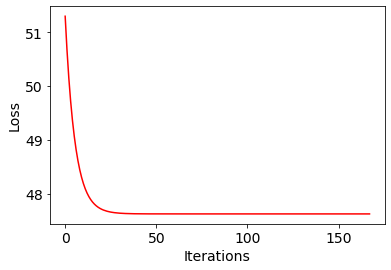

|W|=10.83


In [65]:
# Run gradient descent solver
print('Regularization DISABLED')
w, b, losses = lasso_regression_GD(trainx,trainy,C=0.0, lr=0.001, random_state=9)
# Plot the losses
plt.plot(losses,'r')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

print('|W|={:.2f}'.format(np.linalg.norm(w)))
# thr = 0.06
# print(f'Features that have been killed by lasso (|w| <= {thr}) (as indexes):\n', np.where(np.abs(w) <= thr) )

## Questions

1. Documents all the results in the report.
2. Try with a large value of C (e.g., 20) for lasso and check teh weights and MSE. What do you observe?
3. Compare the coefficients (parameter values) for ridge and lasso for the best setup. What do you observe? Can you explain?
4. Compare MSE of linear, ridge, and lasso. What do you observe?
5. Which among the ridge and lasso gives teh best results on the test? Can you explain why?
6. Can the lasso regression retrieve the 10 features which were used in the equation for y? List them.